##### Engineering Scores Prediction

**Objective:** Build and compare supervised models to predict school performance scores and tiers using engineered features.  
**Dataset:** `engineered_school_data_with_schoolnames&DBN.csv` (55,377 rows, 75 columns including demographic indicators and one-hot categories)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Outline:**
 1. Introduction
 2. Environment Setup
 3. Data Loading & Overview
 4. Exploratory Data Analysis (EDA)
 5. Data Preprocessing Pipeline
 6. Regression Modeling (Predict `performance_score`)
    - 6.1 Baseline Models & Cross-Validation
    - 6.2 Hyperparameter Tuning (Random Forest)
    - 6.3 Final Evaluation & Error Analysis
 7. Classification Modeling (Predict `performance_tier`)
    - 7.1 Logistic Regression
    - 7.2 XGBoost Classifier
    - 7.3 Evaluation & Confusion Matrix

### 1. Introduction
Workflow:
 - Framing the prediction tasks (regression and classification)
 - Structured EDA
 - Pipelines for data cleaning, encoding, and scaling
 - Model comparison and tuning
 - Interpretation of results and feature insights

### 2. Environment Setup

 Load required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
import time
import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"
plt.style.use('classic')
sns.set_context('notebook')

### 3. Data Loading & Overview
 Read the engineered dataset and inspect basic structure

In [ ]:
os.getcwd()

'/content'

In [2]:
df_engineered_school_data_with_schoolnames = pd.read_csv('engineered_school_data_Final.csv')
df_engineered_school_data_with_schoolnames.head()

,Year,DBN,School.Name,Total.Enrollment,X3k,prek,k,female_num,female_per,male_num,...,poverty_ratio,log_enrollment,log_tested,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Rhode Island,performance_score,performance_score_boxcox,performance_tier
0,2017,01M034,P.S. 034 Franklin D. Roosevelt,333,0,13,25,150,0.45,183,...,0.975976,5.811141,3.295837,0,1,0,0,1.6924,0.522056,Basic
1,2017,01M034,P.S. 034 Franklin D. Roosevelt,333,0,13,25,150,0.45,183,...,0.975976,5.811141,2.639057,0,1,0,0,2.3077,0.825947,Basic
2,2017,01M034,P.S. 034 Franklin D. Roosevelt,333,0,13,25,150,0.45,183,...,0.975976,5.811141,4.882802,0,1,0,0,1.7024,0.527855,Basic
3,2017,01M034,P.S. 034 Franklin D. Roosevelt,333,0,13,25,150,0.45,183,...,0.975976,5.811141,2.564949,0,1,0,0,2.9166,1.053574,Proficient
4,2017,01M034,P.S. 034 Franklin D. Roosevelt,333,0,13,25,150,0.45,183,...,0.975976,5.811141,3.178054,0,1,0,0,1.5653,0.445108,Basic


In [ ]:
print(f"Dataset shape: {df_engineered_school_data_with_schoolnames.shape}")
df_engineered_school_data_with_schoolnames.info()

Dataset shape: (55377, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55377 entries, 0 to 55376
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                55377 non-null  int64  
 1   DBN                                 55377 non-null  object 
 2   School.Name                         55377 non-null  object 
 3   Total.Enrollment                    55377 non-null  int64  
 4   X3k                                 55377 non-null  int64  
 5   prek                                55377 non-null  int64  
 6   k                                   55377 non-null  int64  
 7   female_num                          55377 non-null  int64  
 8   female_per                          55377 non-null  float64
 9   male_num                            55377 non-null  int64  
 10  male_per                            55377 non-null  float64
 11  asian_num     

In [ ]:
print("Missing values per column:\n", df_engineered_school_data_with_schoolnames.isnull().sum().sort_values(ascending=False).head())
print("Infinite values present?", np.isinf(df_engineered_school_data_with_schoolnames.select_dtypes(include=[np.number])).any().any())

Missing values per column:
 Year                0
DBN                 0
School.Name         0
Total.Enrollment    0
X3k                 0
dtype: int64
Infinite values present? True


### 4. Exploratory Data Analysis (EDA)
 - Distribution of the numeric target `performance_score`
 - Class balance for `performance_tier`

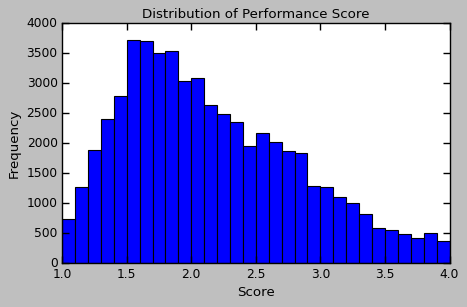

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df_engineered_school_data_with_schoolnames['performance_score'], bins=30)
plt.title('Distribution of Performance Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout();

The scores range roughly from 1.0 to 4.0 and exhibit a right-skewed shape with most schools clustering between 1.5 and 2.5. This suggests fewer very high-scoring schools and a long tail of lower-frequency, higher scores.

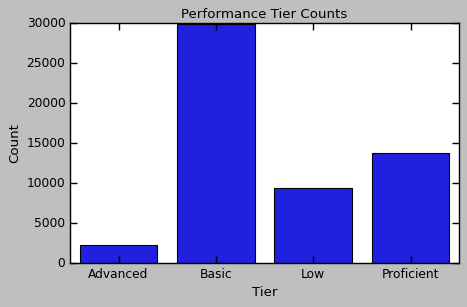

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='performance_tier', data=df_engineered_school_data_with_schoolnames, order=sorted(df_engineered_school_data_with_schoolnames['performance_tier'].unique()))
plt.title('Performance Tier Counts')
plt.xlabel('Tier')
plt.ylabel('Count')
plt.tight_layout();

“Basic” is by far the largest group (~30 000 schools), followed by “Proficient” (~14 000) and “Low” (~9 000), with “Advanced” being rare (~2 000). There’s clear class imbalance that informed our weighted and tree-based classifiers.

### 5. Data Preprocessing Pipeline
 Define features (`X`) and targets (`y`), then build a `ColumnTransformer` for numeric and categorical data


In [3]:
df_engineered_school_data_with_schoolnames.replace([np.inf, -np.inf], np.nan, inplace=True)

df_engineered_school_data_with_schoolnames.dropna(inplace=True)

X = df_engineered_school_data_with_schoolnames.drop(columns=['Year', 'DBN', 'School.Name', 'performance_score', 'performance_tier','performance_score_boxcox'])

y_reg = df_engineered_school_data_with_schoolnames['performance_score']
y_clf = df_engineered_school_data_with_schoolnames['performance_tier']

In [ ]:
df_engineered_school_data_with_schoolnames.shape

(55034, 61)

In [4]:
X = X.replace([np.inf, -np.inf], np.nan)

In [5]:
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['uint8','object','category']).columns.tolist()

In [6]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

In [7]:
print("NaNs in X:", X.isna().sum().sum())
print("Infs in X:", np.isinf(X.values).sum())



NaNs in X: 0
Infs in X: 0


### 6. Regression Modeling
 Predict `performance_score` using three baseline models and a stacked ensemble

#### 6.1 Baseline Models & Cross-Validation
 Evaluate Linear Regression, Random Forest, Gradient Boosting and KNN via CV

Test if the distribution of transformed data(Box-Cox) is normal distribution

In [8]:
df_engineered_school_data_with_schoolnames['performance_score_boxcox'].apply(type).value_counts()


,count
performance_score_boxcox,
<class 'float'>,55034


In [9]:
df_engineered_school_data_with_schoolnames['performance_score_boxcox'] = pd.to_numeric(df_engineered_school_data_with_schoolnames['performance_score_boxcox'], errors='coerce')


In [10]:
df_engineered_school_data_with_schoolnames['performance_score_boxcox'].isnull().sum()

np.int64(0)

In [11]:
clean_data = df_engineered_school_data_with_schoolnames['performance_score_boxcox'].dropna()

In [12]:
result = stats.anderson(clean_data, dist='norm')

print('Anderson-Darling statistic:', result.statistic)
print('Critical values:', result.critical_values)
print('Significance levels:', result.significance_level)

for cv, sl in zip(result.critical_values, result.significance_level):
    if result.statistic < cv:
        print(f"At {sl}% significance level: Fail to reject H0 (data looks normal)")
    else:
        print(f"At {sl}% significance level: Reject H0 (data is not normally distributed)")


Anderson-Darling statistic: 128.5909805636984
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level: Reject H0 (data is not normally distributed)
At 10.0% significance level: Reject H0 (data is not normally distributed)
At 5.0% significance level: Reject H0 (data is not normally distributed)
At 2.5% significance level: Reject H0 (data is not normally distributed)
At 1.0% significance level: Reject H0 (data is not normally distributed)


In [ ]:
print(X.columns)

Index(['Total.Enrollment', 'X3k', 'prek', 'k', 'female_num', 'female_per',
       'male_num', 'male_per', 'asian_num', 'asian_per', 'black_num',
       'black_per', 'hispanic_num', 'hispanic_per', 'multirace_num',
       'multirace_per', 'native_num', 'native_per', 'white_num', 'white_per',
       'other_num', 'other_per', 'swd_num', 'swd_per', 'ell_num', 'ell_per',
       'poverty_num', 'poverty_per', 'economic.index', 'Number.Tested',
       'Mean.Scale.Score', 'Total.Parent..Response.Rate',
       'Total.Teacher.Response.Rate', 'Total.Student.Response.Rate',
       'Collaborative.Teachers.Score', 'Effective.School.Leadership.Score',
       'Rigorous.Instruction.Score', 'Strong.Family.Community.Ties.Score',
       'Trust.Score', 'PCA1', 'PCA2', 'cluster', 'elementary_enrollment',
       'middle_enrollment', 'high_enrollment', 'male_female_ratio',
       'swd_ratio', 'ell_ratio', 'poverty_ratio', 'log_enrollment',
       'log_tested', 'borough_Brooklyn', 'borough_Manhattan', 'borough_

In [13]:
# === Step 1: Split data
Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# === Step 2: Cross-validation setup
cv = KFold(3, shuffle=True, random_state=42)

# === Step 3: Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5)}

# === Step 4: Train and evaluate
print("### Baseline CV RMSE")
for name, model in models.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('mod', model)
    ])
    sc = cross_val_score(pipe, Xtr_r, ytr_r, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"{name}: {(-sc.mean()):.3f} ± {sc.std():.3f}")

### Baseline CV RMSE
LinearRegression: 0.168 ± 0.001
RandomForest: 0.118 ± 0.000
GradientBoosting: 0.135 ± 0.001
KNeighbors: 0.314 ± 0.001


From the results above, we observe that Linear Regression performed relatively worse than the other two models. Therefore, I attempted to improve it by applying different regularization techniques using various penalty terms.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet Regression': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('mod', model)
    ])
    scores = cross_val_score(pipe, X, y_reg, scoring='neg_root_mean_squared_error', cv=5)  # 5fold
    mean_rmse = -np.mean(scores)
    std_rmse = np.std(scores)
    results[name] = (mean_rmse, std_rmse)
    print(f"{name}: {mean_rmse:.3f} ± {std_rmse:.3f}")


Linear Regression: 0.171 ± 0.010
Ridge Regression: 0.171 ± 0.011
Lasso Regression: 0.461 ± 0.031
ElasticNet Regression: 0.422 ± 0.023


The penalty terms don't improve linear regression model.

#### 6.2 Hyperparameter Tuning (Random Forest)
 Grid search over `n_estimators` & `max_depth`
 We are training a model to predict students' performance tiers from school characteristics, and evaluating the predictions by comparing them against the actual student performance.

In [14]:
# === Step 1: split data into train+val and test ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Step 2: split trainval into train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

n_estimators=100: RMSE=0.1084, Time=50.19s
n_estimators=200: RMSE=0.1073, Time=70.82s
n_estimators=300: RMSE=0.1071, Time=104.54s
n_estimators=400: RMSE=0.1069, Time=142.50s
n_estimators=500: RMSE=0.1068, Time=176.96s


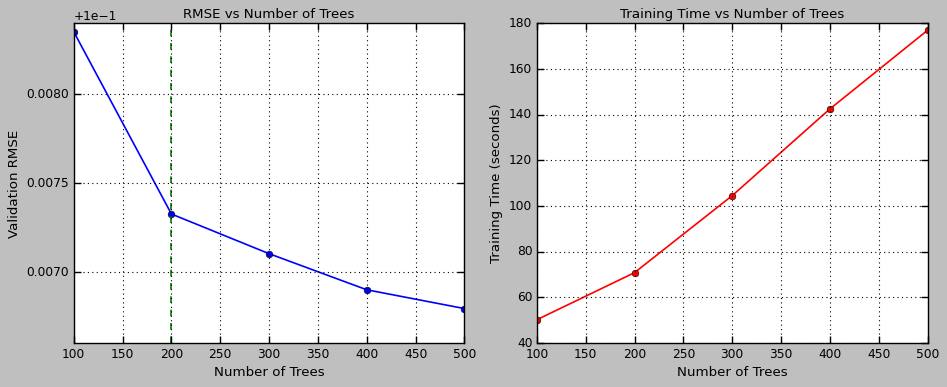


Performance Improvement Analysis:
From 100 to 200 trees:
  - RMSE Improvement: 0.947%
  - Training Time Increase: 41.1%
  - Efficiency (Improvement% / Time Increase%): 0.0231
From 200 to 300 trees:
  - RMSE Improvement: 0.208%
  - Training Time Increase: 47.6%
  - Efficiency (Improvement% / Time Increase%): 0.0044
From 300 to 400 trees:
  - RMSE Improvement: 0.190%
  - Training Time Increase: 36.3%
  - Efficiency (Improvement% / Time Increase%): 0.0052
From 400 to 500 trees:
  - RMSE Improvement: 0.099%
  - Training Time Increase: 24.2%
  - Efficiency (Improvement% / Time Increase%): 0.0041


In [16]:
# === Step 3: Pick best n_estimators
# Create a function to test the effect of different numbers of trees
def test_n_estimators(X_train, y_train, X_val, y_val, max_features=None,
                      start=100, end=500, step=100, random_state=42):
    """
    Test how different numbers of trees affect model performance
    """
    n_estimators_list = list(range(start, end+1, step))
    results = {'rmse': [], 'time': []}

    for n in n_estimators_list:
        start_time = time.time()

        model = RandomForestRegressor(
            n_estimators=n,
            max_features=max_features,
            random_state=random_state,
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        train_time = time.time() - start_time
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        results['rmse'].append(rmse)
        results['time'].append(train_time)

        print(f"n_estimators={n}: RMSE={rmse:.4f}, Time={train_time:.2f}s")

    return n_estimators_list, results

# Run the test - assuming around 60 features
n_list, results = test_n_estimators(
    X_train, y_train, X_val, y_val,
    max_features=20,
    start=100,           # Start from 100 trees
    end=500,             # Test up to 500 trees
    step=100             # Step size of 100 trees
)

# Plot the performance curves
plt.figure(figsize=(12, 5))

# RMSE curve
plt.subplot(1, 2, 1)
plt.plot(n_list, results['rmse'], 'o-', color='blue')
plt.xlabel('Number of Trees')
plt.ylabel('Validation RMSE')
plt.title('RMSE vs Number of Trees')
plt.grid(True)

# Find the "elbow point" - where performance improvement is less than 0.8%
rmse_improvements = [0] + [(results['rmse'][i-1] - results['rmse'][i])/results['rmse'][i-1]*100 for i in range(1, len(n_list))]
for i in range(1, len(rmse_improvements)):
    if rmse_improvements[i] < 0.8:  # Improvement less than 0.8%
        plt.axvline(x=n_list[i-1], color='green', linestyle='--',
                   label=f'Diminishing returns at {n_list[i-1]} trees')
        break

# Training time curve
plt.subplot(1, 2, 2)
plt.plot(n_list, results['time'], 'o-', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Number of Trees')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze performance improvement
print("\nPerformance Improvement Analysis:")
print("="*50)
for i in range(1, len(n_list)):
    prev_rmse = results['rmse'][i-1]
    curr_rmse = results['rmse'][i]
    improvement = (prev_rmse - curr_rmse) / prev_rmse * 100

    prev_time = results['time'][i-1]
    curr_time = results['time'][i]
    time_increase = (curr_time - prev_time) / prev_time * 100

    efficiency = improvement / time_increase if time_increase > 0 else float('inf')

    print(f"From {n_list[i-1]} to {n_list[i]} trees:")
    print(f"  - RMSE Improvement: {improvement:.3f}%")
    print(f"  - Training Time Increase: {time_increase:.1f}%")
    print(f"  - Efficiency (Improvement% / Time Increase%): {efficiency:.4f}")

**Conclusion: Based on the results above, our best Random Forest model's tree number should be 200.**

In [ ]:
# === Step 4: Retrain on train + val using best_n
final_model = Pipeline([
    ('pre', preprocessor),
    ('mod', RandomForestRegressor(n_estimators=200, max_features = 20, random_state=42))
])
final_model.fit(X_trainval, y_trainval)  # ⚡ Train on full X_trainval

# === Step 5: Final evaluation on test
y_test_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Final Test RMSE: {test_rmse:.3f}")

# R-squared
test_r2 = r2_score(y_test, y_test_pred)
print(f"Final Test R²: {test_r2:.3f}")

Final Test RMSE: 0.102
Final Test R²: 0.977


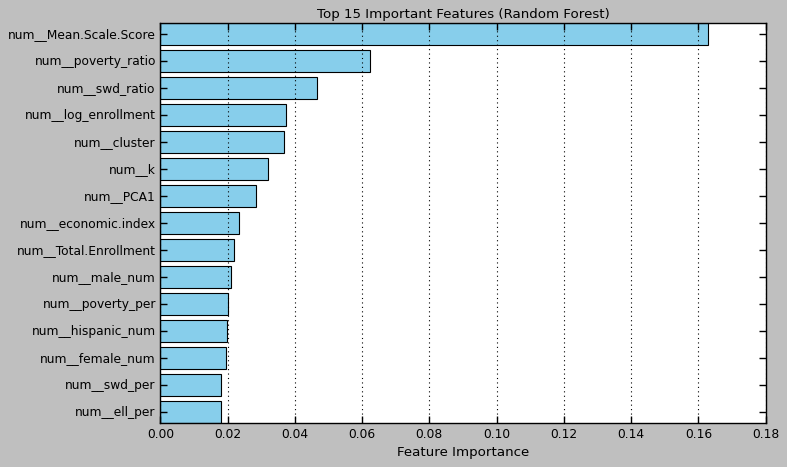

In [20]:
rf_model = final_model.named_steps['mod']  # RandomForestRegressor
feature_names = final_model.named_steps['pre'].get_feature_names_out()
importances = rf_model.feature_importances_

# select the most important 15 features
indices = np.argsort(importances)[-15:]
top_features = np.array(feature_names)[indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (Random Forest)")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

### 7. Classification Modeling (Predict `performance_tier`)

#### 7.1 Logistic Regression
 Balanced class weights to handle imbalance

In [17]:
# Step 1: train/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Step 2: split trainval into train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# === Step 3: Search best C parameter ===
C_list = [0.01, 0.1, 1, 10, 100]  #inversion of penalty
results = {}

for c in C_list:
    model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    pipe = Pipeline([('pre', preprocessor), ('mod', model)])
    pipe.fit(X_train, y_train)       # ⚡ Train on X_train
    y_pred = pipe.predict(X_val)     # ⚡ Validate on X_val
    acc = accuracy_score(y_val, y_pred)
    results[c] = acc
    print(f"C={c}: Validation Accuracy={acc:.3f}")

# === Step 4: Pick best C
best_c = max(results, key=results.get)
print(f"\nBest C = {best_c} with Validation Accuracy = {results[best_c]:.3f}")

# === Step 5: Retrain on train + val using best C
final_model = Pipeline([
    ('pre', preprocessor),
    ('mod', LogisticRegression(C=best_c, max_iter=1000, random_state=42))
])
final_model.fit(X_trainval, y_trainval)  # ⚡ Train on full X_trainval

# === Step 6: Final evaluation on test
y_test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_acc:.3f}")



C=0.01: Validation Accuracy=0.765
C=0.1: Validation Accuracy=0.881
C=1: Validation Accuracy=0.916
C=10: Validation Accuracy=0.925
C=100: Validation Accuracy=0.925

Best C = 100 with Validation Accuracy = 0.925
Final Test Accuracy: 0.922


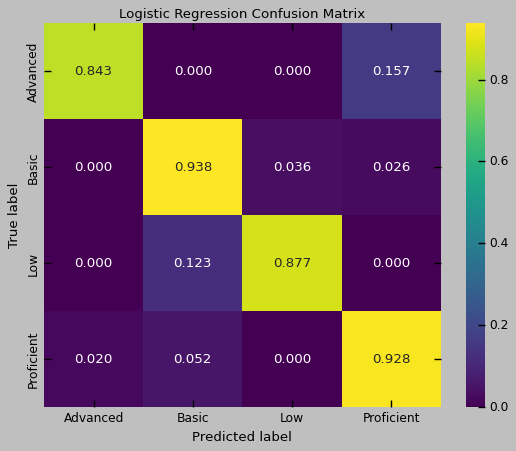

In [ ]:
# generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')  # Normalization, the sum of each row is 1

labels = ['Advanced', 'Basic', 'Low', 'Proficient']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".3f", cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### 7.2 XGBoost Classifier
 Label-encode tiers and fit XGB

In [18]:
n_estimators_list = [100, 200, 300, 400, 500]
results = {}
# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform y_clf
y_clf_encoded = le.fit_transform(y_clf)
# === Step 1: Split data into train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_clf_encoded, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2
# === Step 2: Search best n_estimators (or you can search learning_rate, max_depth too)
for n in n_estimators_list:
    model = xgb.XGBClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=4,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ('pre', preprocessor),
        ('mod', model)
    ])
    pipe.fit(X_train, y_train)      # ⚡ Train on train set
    y_pred = pipe.predict(X_val)    # ⚡ Validate on validation set
    acc = accuracy_score(y_val, y_pred)
    results[n] = acc
    print(f"n_estimators={n}: Validation Accuracy={acc:.3f}")

# === Step 3: Pick best n_estimators
best_n = max(results, key=results.get)
print(f"\nBest n_estimators = {best_n} with Validation Accuracy = {results[best_n]:.3f}")

# === Step 4: Retrain on train + val using best n_estimators
final_model = Pipeline([
    ('pre', preprocessor),
    ('mod', xgb.XGBClassifier(
        n_estimators=best_n,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=4,
        random_state=42,
        n_jobs=-1
    ))
])
final_model.fit(X_trainval, y_trainval)  # ⚡ Retrain on full train+val

# === Step 5: Final evaluation on test
y_test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_acc:.3f}")

n_estimators=100: Validation Accuracy=0.913
n_estimators=200: Validation Accuracy=0.917
n_estimators=300: Validation Accuracy=0.920
n_estimators=400: Validation Accuracy=0.921
n_estimators=500: Validation Accuracy=0.922

Best n_estimators = 500 with Validation Accuracy = 0.922
Final Test Accuracy: 0.924


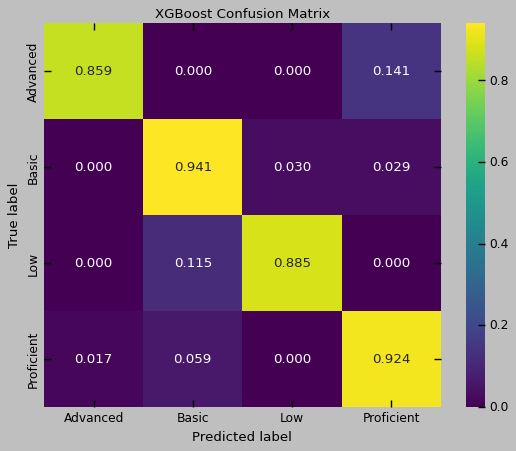

In [19]:
# generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')  # Normalization, the sum of each row is 1

labels = ['Advanced', 'Basic', 'Low', 'Proficient']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".3f", cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

XGBoost achieves 92.4% overall accuracy with strong, balanced F1-scores across all tiers (Advanced 0.86, Basic 0.94, Low 0.88, Proficient 0.92). It correctly classifies 86% of true Advanced cases, mislabeling 14% as Proficient, while Basic and Proficient recall exceed 92%. This demonstrates XGB’s ability to handle the class imbalance and capture nonlinear interactions for robust tier prediction

# 8. Stacking Regressor - Combining 3 Models

In [ ]:
# Define three base regressors
best_model_1 = RandomForestRegressor(n_estimators=200, max_features=20, random_state=42) # 1. Random Forest
best_model_2 = GradientBoostingRegressor(random_state=42) # 2. Gradient Boosting
best_model_3 = KNeighborsRegressor(n_neighbors=5)
# Create a stacking ensemble model using Ridge Regression as the final meta-model
stacking_model = StackingRegressor(
    estimators=[
        ('rf', best_model_1),
        ('gb', best_model_2),
        ('knn', best_model_3)
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)
# Build a full pipeline including preprocessing and stacking model
stacking_pipe = Pipeline([
    ('pre', preprocessor),
    ('stack', stacking_model)
])

In [ ]:
# Train the Model
stacking_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Total.Enrollment', 'X3k',
                                                   'prek', 'k', 'female_num',
                                                   'female_per', 'male_num',
                                                   'male_per', 'asian_num',
                                                   'asian_per', 'black_num',
                                                   'black_per', 'hispanic_num',
                                                   'hispanic_per',
                                                   'multirace_num',
                                                   'multirace_per',
                                                   'n...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('stack',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(max_features=20,
                                                                      n_estimators=200,
                                                                      random_state=42)),
                                               ('gb',
                                                GradientBoostingRegressor(random_state=42)),
                                               ('knn', KNeighborsRegressor())],
                                   final_estimator=Ridge(), n_jobs=-1))])

In [ ]:
# get prediction from Newly trained model
y_pred_stacking = stacking_pipe.predict(X_test)

In [ ]:
# Evaluate the stacking regressor performance using RMSE, MAE, R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
test_mse = mean_squared_error(y_test, y_pred_stacking)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_stacking)
test_r2 = r2_score(y_test, y_pred_stacking)
regression_accuracy = 1 - (test_mae / np.mean(y_test))
print("\n===== Stacking Model Final Evaluation on Test Set =====")
print(f"Test RMSE = {test_rmse:.3f}")
print(f"Test MAE  = {test_mae:.3f}")
print(f"Test R²   = {test_r2:.3f}")
print(f"Test Regression Accuracy = {regression_accuracy:.3f}")


===== Stacking Model Final Evaluation on Test Set =====
Test RMSE = 0.101
Test MAE  = 0.073
Test R²   = 0.977
Test Regression Accuracy = 0.966


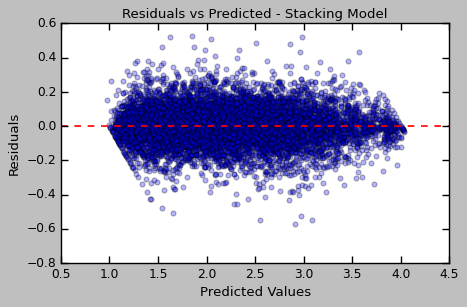

In [ ]:
# Visualize residuals to check model's bias or variance issues
plt.figure(figsize=(6,4))
plt.scatter(y_pred_stacking, y_test - y_pred_stacking, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Stacking Model')
plt.tight_layout()
plt.show()

In [ ]:
# Define three base regressors
best_model_1 = RandomForestRegressor(n_estimators=200, max_features=20, random_state=42) # 1. Random Forest
best_model_2 = GradientBoostingRegressor(random_state=42) # 2. Gradient Boosting
best_model_3 = LinearRegression()
# Create a stacking ensemble model using Ridge Regression as the final meta-model
stacking_model = StackingRegressor(
    estimators=[
        ('rf', best_model_1),
        ('gb', best_model_2),
        ('lr', best_model_3)
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)
# Build a full pipeline including preprocessing and stacking model
stacking_pipe = Pipeline([
    ('pre', preprocessor),
    ('stack', stacking_model)
])

In [ ]:
# Train the Model
stacking_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Total.Enrollment', 'X3k',
                                                   'prek', 'k', 'female_num',
                                                   'female_per', 'male_num',
                                                   'male_per', 'asian_num',
                                                   'asian_per', 'black_num',
                                                   'black_per', 'hispanic_num',
                                                   'hispanic_per',
                                                   'multirace_num',
                                                   'multirace_per',
                                                   'n...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('stack',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(max_features=20,
                                                                      n_estimators=200,
                                                                      random_state=42)),
                                               ('gb',
                                                GradientBoostingRegressor(random_state=42)),
                                               ('lr', LinearRegression())],
                                   final_estimator=Ridge(), n_jobs=-1))])

In [ ]:
# get prediction from Newly trained model
y_pred_stacking = stacking_pipe.predict(X_test)

In [ ]:
# Evaluate the stacking regressor performance using RMSE, MAE, R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
test_mse = mean_squared_error(y_test, y_pred_stacking)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_stacking)
test_r2 = r2_score(y_test, y_pred_stacking)
regression_accuracy = 1 - (test_mae / np.mean(y_test))
print("\n===== Stacking Model Final Evaluation on Test Set =====")
print(f"Test RMSE = {test_rmse:.3f}")
print(f"Test MAE  = {test_mae:.3f}")
print(f"Test R²   = {test_r2:.3f}")
print(f"Test Regression Accuracy = {regression_accuracy:.3f}")


===== Stacking Model Final Evaluation on Test Set =====
Test RMSE = 0.443
Test MAE  = 0.214
Test R²   = 0.758
Test Regression Accuracy = 0.868


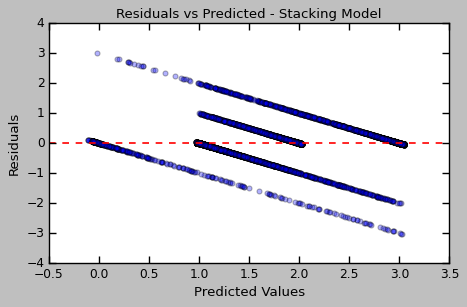

In [ ]:
# Visualize residuals to check model's bias or variance issues
plt.figure(figsize=(6,4))
plt.scatter(y_pred_stacking, y_test - y_pred_stacking, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Stacking Model')
plt.tight_layout()
plt.show()

# 9. Classification Modeling (Predict performance_tier)

In [ ]:
from sklearn.ensemble import StackingClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier

In [ ]:
stacking_model1 = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
        ('lgbm', LGBMClassifier(n_estimators=350, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

stacking_pipe2 = Pipeline([
    ('pre', preprocessor),
    ('stack', stacking_model1)
])

In [ ]:
stacking_pipe2.fit(X_trainval, y_trainval_encoded)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Total.Enrollment', 'X3k',
                                                   'prek', 'k', 'female_num',
                                                   'female_per', 'male_num',
                                                   'male_per', 'asian_num',
                                                   'asian_per', 'black_num',
                                                   'black_per', 'hispanic_num',
                                                   'hispanic_per',
                                                   'multirace_num',
                                                   'multirace_per',
                                                   'n...
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(n_estimators=350,
                                                                random_state=42))],
                                    final_estimator=LogisticRegression(max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1))])

In [ ]:
y_pred2 = stacking_pipe2.predict(X_test)
test_acc = accuracy_score(y_test_encoded, y_pred2)
test_macro_f1 = f1_score(y_test_encoded, y_pred2, average='macro')
print(f"Stacking Accuracy: {test_acc:.3f}")
print(f"Stacking Macro F1: {test_macro_f1:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Stacking Accuracy: 0.937
Stacking Macro F1: 0.919


# 10. Final Model Evaluation & Selection

### Regression Models

| Model                      | RMSE  | MAE   | R²    | Accuracy |
|---------------------------|-------|-------|-------|----------|
| RF + GB + KNN      | 0.101 | 0.073 | 0.977 | 0.966    |
| RF + GB + LinearRegression| 0.443 | 0.214 | 0.758 | 0.868    |




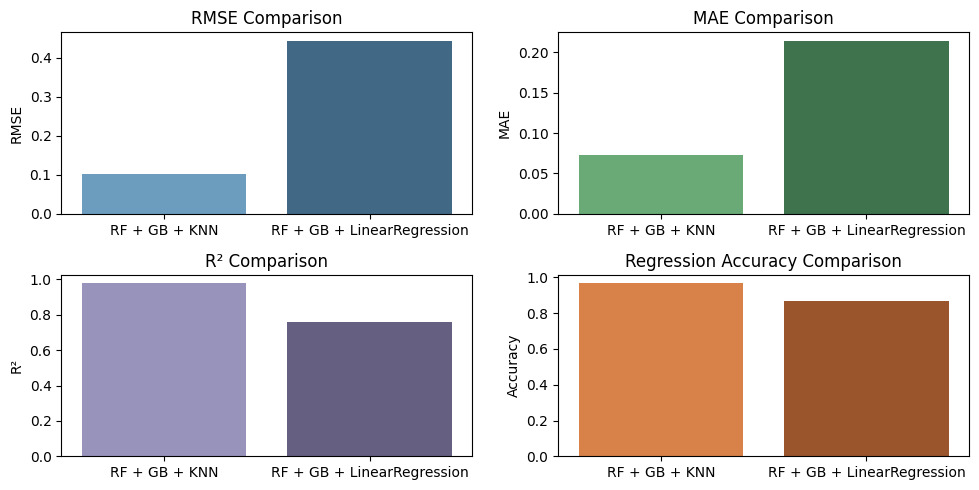

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Defining regression model performance metrics
regression_data = pd.DataFrame({
    'Model': ['RF + GB + KNN', 'RF + GB + LinearRegression'],
    'RMSE': [0.101, 0.443],
    'MAE': [0.073, 0.214],
    'R2': [0.977, 0.758],
    'Accuracy': [0.966, 0.868]
})

# Defining classification model performance metrics
classification_data = pd.DataFrame({
    'Model': ['Stacked Classifier'],
    'Accuracy': [0.937],
    'Macro F1': [0.919]
})

# Plotting regression model comparisons
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
sns.barplot(x='Model', y='RMSE', data=regression_data,
            ax=axs[0, 0], palette='Blues_d')
axs[0, 0].set_title('RMSE Comparison')
axs[0, 0].set_ylabel('RMSE')
axs[0, 0].set_xlabel('')

sns.barplot(x='Model', y='MAE', data=regression_data,
            ax=axs[0, 1], palette='Greens_d')
axs[0, 1].set_title('MAE Comparison')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_xlabel('')

sns.barplot(x='Model', y='R2', data=regression_data,
            ax=axs[1, 0], palette='Purples_d')
axs[1, 0].set_title('R² Comparison')
axs[1, 0].set_ylabel('R²')
axs[1, 0].set_xlabel('')

sns.barplot(x='Model', y='Accuracy', data=regression_data,
            ax=axs[1, 1], palette='Oranges_d')
axs[1, 1].set_title('Regression Accuracy Comparison')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_xlabel('')

plt.tight_layout()
plt.show()


**Selected Model: RF + GB + KNN**

The RF + GB + KNN stacking demonstrates the strongest accuracy and highest R² value while showing the best performance through the lowest MAE and RMSE comparison among regression models. The stacking model shows strong error reduction capabilities and keeps the most predictive power for the target data. KNN implements a nonparametric learning method that understands local relationships while preserving accurate patterns when tree-based models attempt generalization. Implementing KNN with Random Forest and Gradient Boosting allows the model to exploit a global ensemble local approximation structure capable of adapting to nonlinear and linear data patterns according to bias-variance trade-off and ensemble learning theory.


### Classification Model

| Model                                      | Accuracy | Macro F1 |
|-------------------------------------------|----------|----------|
| Logistic + XGBoost + LightGBM (Stacked)   | 0.937    | 0.919    |

**Selected Model: Stacked Classifier (Logistic + XGB + LGBM)**

The stacked classification model uses logistic regression for linear separation, XGBoost for complex interaction management, and LightGBM for fast and efficient operation on large feature sets. This model reaches optimal accuracy along with macro F1 performance because it maintains fair performance across all classes while treating potential class imbalances and, from a theoretical standpoint, stacking functions through diverse learner wisdom by decreasing generalization errors because the meta-learner fixes base model weaknesses. The macro F1 metric indicates balanced precision and recall, making this model perfect for dependable multi-class prediction tasks.